In [5]:
import os
import json
import time
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd

import cartopy.feature as cf
import cartopy.crs as ccrs

from matplotlib import patches
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from playsound import playsound

import psutil
from joblib import Parallel, delayed

from scipy.optimize import differential_evolution

from pathos.multiprocessing import ProcessingPool as Pool

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append(os.path.abspath(".."))
from function import ART_downscale as ART_down
from function import ART_preprocessing as ART_pre

## Downscaling to Veneto region

In [6]:
# product, time_reso = 'IMERG', '1dy'

# product, time_reso = 'IMERG', '3h'
# product, time_reso = 'MSWEP', '3h'
product, time_reso = 'CMORPH', '3h'
# product, time_reso = 'PERSIANN', '1dy'
# product, time_reso = 'SM2RAIN', '1dy'

yy_s, yy_e = 2002, 2012
lon_min, lon_max, lat_min, lat_max = 10.5, 13.5, 44.5, 47

In [7]:
json_read = f'../json/{product}_{time_reso}.json'

if os.path.exists(json_read):
    with open (json_read) as f:
        param = json.load(f)
else:
    raise SystemExit(f"File not found: {json_read}")

print(f'Read json file   : {json_read.split('/')[-1]}')
print(f'Number of threads: {param['GAMMA_cores']}')

Read json file   : CMORPH_3h.json
Number of threads: 27


In [8]:
dir_base = os.path.join('/','media','arturo','Arturo','Data','Italy','Satellite')

In [9]:
veneto_dir = os.path.join('/','media','arturo','Arturo','Data','shapes','Europa','Italy')

if os.path.exists(veneto_dir):
    VENETO = gpd.read_file(os.path.join(veneto_dir,'Veneto.geojson'))
else:
    raise SystemExit(f"File not found: {veneto_dir}")

In [10]:
print(f'Reading data: {param['file']}')
if product == 'SM2RAIN':
    dir_data = os.path.join(dir_base,product,'ASCAT',time_reso,param['file'])
else:
    dir_data = os.path.join(dir_base,product,time_reso,param['file'])

PRE_data = xr.open_dataset(dir_data)
PRE_data = PRE_data.sel(time=PRE_data.time.dt.year.isin([np.arange(yy_s,yy_e+1)]))

if product == 'MSWEP' or product == 'PERSIANN' or product == 'SM2RAIN':
    PRE_data = PRE_data.sel(lat=slice(lat_max+1.5, lat_min-1.5), lon=slice(lon_min-1.5, lon_max+1.5))
else:
    PRE_data = PRE_data.sel(lat=slice(lat_min-1.5, lat_max+1.5), lon=slice(lon_min-1.5, lon_max+1.5))

lats = PRE_data['lat'].data
lons = PRE_data['lon'].data

lon2d, lat2d = np.meshgrid(lons, lats)

nlon = np.size(lons)
nlat = np.size(lats)
ntime = len(PRE_data['time'])

# year_vector = np.unique(pd.to_datetime(PRE_data['time']).year)

PRE_data

Reading data: CMORPH_Italy_3hr_1998_01_01_2023_12_31.nc


<xarray.Dataset> Size: 62MB
Dimensions:  (time: 32144, lat: 20, lon: 24)
Coordinates:
  * lat      (lat) float32 80B 43.12 43.38 43.62 43.88 ... 47.38 47.62 47.88
  * lon      (lon) float32 96B 9.125 9.375 9.625 9.875 ... 14.38 14.62 14.88
  * time     (time) datetime64[ns] 257kB 2002-01-01 ... 2012-12-31T21:00:00
Data variables:
    PRE      (time, lat, lon) float32 62MB ...
Attributes:
    description:  CMORPH hourly data for Italy region in 1998 to 2023

In [11]:
# Extracting lat and lon points for Study area (VENETO)
if product == 'MSWEP' or product == 'PERSIANN' or product == 'SM2RAIN':
    ds_veneto = PRE_data.sel(lat=slice(lat_max, lat_min), lon=slice(lon_min, lon_max))
else:
    ds_veneto = PRE_data.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))

if time_reso == '3h':
    PRE_mean = ds_veneto.resample(time ='D').sum(dim='time', skipna=False).mean(dim='time', skipna=True)
elif time_reso == '1dy':
    PRE_mean = ds_veneto.mean(dim='time', skipna=True)
else:
    raise SystemExit(f"Time resolution not found: {time_reso}")

lat_ref = ds_veneto.lat.values
lon_ref = ds_veneto.lon.values

ndices_lat = np.where(np.isin(lats, lat_ref))[0]
ndices_lon = np.where(np.isin(lons, lon_ref))[0]

lon2d_ref, lat2d_ref = np.meshgrid(lon_ref, lat_ref)

del ds_veneto

PRE_mean

<xarray.Dataset> Size: 568B
Dimensions:  (lat: 10, lon: 12)
Coordinates:
  * lat      (lat) float32 40B 44.62 44.88 45.12 45.38 ... 46.38 46.62 46.88
  * lon      (lon) float32 48B 10.62 10.88 11.12 11.38 ... 12.88 13.12 13.38
Data variables:
    PRE      (lat, lon) float32 480B 1.853 1.702 1.577 ... 1.857 2.041 2.203

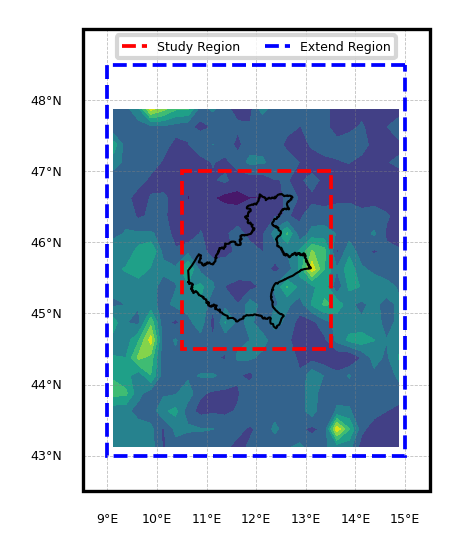

In [16]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(2,2),dpi=300)
gs = gridspec.GridSpec(1,1)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([lon_min-2, lon_max+2, lat_min-2, lat_max+2],crs=proj)
VENETO.plot(facecolor='None', ax=ax1, zorder=10, linewidth=0.5)

ax1.add_patch(patches.Rectangle((lon_max,lat_max),lon_min-lon_max,lat_min-lat_max,linestyle='--',linewidth=0.9,edgecolor='r',facecolor='None',zorder=5))
ax1.add_patch(patches.Rectangle((lon_max+1.5,lat_max+1.5),(lon_min-1.5)-(lon_max+1.5),(lat_min-1.5)-(lat_max+1.5),linestyle='--',linewidth=0.9,edgecolor='b',facecolor='None',zorder=5))

a1 = ax1.contourf(lon2d, lat2d, PRE_data['PRE'].max(dim='time'))

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

ax1.plot([],[],linestyle='--',linewidth=0.9,color='r', label='Study Region')
ax1.plot([],[],linestyle='--',linewidth=0.9,color='b', label='Extend Region')

ax1.legend(fontsize=3,ncols=2,loc='upper center')

In [112]:
def beta_3h_1dy(DATA_in, time_reso, lat_c, lon_c, PARAM):
    if time_reso == '3h':
        PRE_daily = DATA_in.resample(time ='D').sum(dim='time', skipna=False)
        BOX = ART_pre.create_box_v2(PRE_daily, lat_c, lon_c, PARAM['npix'])
        tscales = np.array([1, 2, 3, 4, 5, 6, 8, 10, 12, 16, 20, 24, 36, 48, 96])*param['dt']
    elif time_reso == '1dy':
        BOX = ART_pre.create_box_v2(DATA_in, lat_c, lon_c, PARAM['npix'])
        tscales = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])*param['dt']
    else:
        print(f'Erorr: {time_reso} not valid')
        return None
    
    print(f"Neighborhood area: {BOX.sizes['lat']}x{BOX.sizes['lon']}")
    
    BOX = BOX.transpose("lon", "lat", "time")
    BOX = BOX['PRE']
    
    smax = BOX.shape[0]
    tscales = tscales[tscales < param['tmax'] + 0.001]
    xscales = np.arange(1, smax+1)
    xscales_km = xscales*param['L1']
    
    WET_MATRIX = ART_pre.space_time_scales_agregations(
                BOX, 
                param['L1'], 
                param['condition'], 
                tscales, 
                xscales, 
                2*param['npix']+1, 
                param['thresh'])
    
    nxscales = np.size(xscales)
    
    tscales_INTER = np.linspace(np.min(tscales), np.max(tscales), param['ninterp'])
    WET_MATRIX_INTER = np.zeros((param['ninterp'], nxscales))

    for col in range(nxscales):
        WET_MATRIX_INTER[:, col] = np.interp(tscales_INTER, tscales, WET_MATRIX[:, col])

    WET_MATRIX_EXTRA, new_spatial_scale = ART_pre.wet_matrix_extrapolation(
                WET_MATRIX_INTER, 
                xscales_km, 
                tscales_INTER, 
                param['L1'], 
                param['npix'])

    origin_ref = [param['origin_x'], param['origin_t']]
    target_ref = [param['target_x'], param['target_t']]

    beta = ART_down.compute_beta(WET_MATRIX_EXTRA, origin_ref, target_ref, new_spatial_scale, tscales_INTER)

    return beta


In [ ]:
# def beta_3h_1dy_OLD(DATA_in, time_reso, lat_c, lon_c, param):
#     if time_reso == '3h':
#         PRE_daily = DATA_in.resample(time ='D').sum(dim='time', skipna=False)
#         box_3h, _ = create_box(PRE_daily, lat_c, lon_c, param['npix'], param['radio'])
#         tscales = np.array([1, 2, 3, 4, 5, 6, 8, 10, 12, 16, 20, 24, 36, 48, 96])*param['dt']
#     elif time_reso == '1dy':
#         box_3h, _ = create_box(DATA_in, lat_c, lon_c, param['npix'], param['radio'])
#         tscales = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])*param['dt']
#     else:
#         print(f'Erorr: {time_reso} not valid')
#         return None

#     print(f'neihgborhood area: {box_3h.shape[0]}x{box_3h.shape[1]}')

#     smax = box_3h.shape[0]
#     tscales = tscales[tscales < param['tmax'] + 0.001]
#     xscales = np.arange(1, smax+1)
#     xscales_km = xscales*param['L1']

#     WET_MATRIX = space_time_scales_agregations(
#                 box_3h, 
#                 param['L1'], 
#                 param['condition'], 
#                 tscales, 
#                 xscales, 
#                 param['npix'], 
#                 param['thresh'])

#     nxscales = np.size(xscales)

#     tscales_INTER = np.linspace(np.min(tscales), np.max(tscales), param['ninterp'])
#     WET_MATRIX_INTER = np.zeros((param['ninterp'], nxscales))

#     for col in range(nxscales):
#         WET_MATRIX_INTER[:, col] = np.interp(tscales_INTER, tscales, WET_MATRIX[:, col])

#     WET_MATRIX_EXTRA, new_spatial_scale = wet_matrix_extrapolation(
#                 WET_MATRIX_INTER, 
#                 xscales_km, 
#                 tscales_INTER, 
#                 param['L1'], 
#                 param['npix'])

#     origin_ref = [param['origin_x'], param['origin_t']]
#     target_ref = [param['target_x'], param['target_t']]

#     beta = compute_beta(WET_MATRIX_EXTRA, origin_ref, target_ref, new_spatial_scale, tscales_INTER)

#     return beta


In [115]:
beta = beta_3h_1dy(PRE_data, time_reso, lats[5], lons[5], param)

Neighborhood area: 5x5


In [116]:
beta

np.float64(1.2507490518570605)